In [1]:
import os
import json
import pickle
import numpy as np
import pandas as pd
import seaborn as sbn
import matplotlib.pyplot as plt
import matplotlib
import traceback
from tqdm import tqdm
from collections import Counter
from itertools import product, combinations
from sklearn.datasets import load_svmlight_file
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score, accuracy_score

In [3]:
from sys import path
path.append("../utils/")

from utils import load_preds, load_preds_clfs_bert, get_datasets

In [7]:
DATASETS = ["20ng", "acm", "webkb", "reut"]

ALGORITHMS = ["centroide", "gbm", "knn", "lr", "rf", "svm", "bert"]

BERT_ALGS = ["gbm", "knn", "lr", "rf", "svm"]

In [8]:
CLF_ID = { clf:idx for clf, idx in zip(ALGORITHMS, range(len(ALGORITHMS)))}
CLF_ID

{'centroide': 0, 'gbm': 1, 'knn': 2, 'lr': 3, 'rf': 4, 'svm': 5, 'bert': 6}

In [9]:
d_preds = load_preds(DATASETS, ALGORITHMS, from_scratch=True)

#d_preds = load_preds_clfs_bert(DATASETS, BERT_ALGS)

LOADING PREDS FROM SCRATCH


280it [00:00, 2614.27it/s]


In [10]:
def all_against_all(preds, df):

    rates = []
    for clf1, clf2 in combinations(preds.keys(), 2):

        p1 = preds[clf1]
        p2 = preds[clf2]

        # Looking at where the classifiers predicted equal.
        total_common = np.sum(p1 == p2) / df.shape[0]
        total_common = np.round(total_common * 100, decimals=2)

        hits_p1 = df.classes.values == p1
        hits_p2 = df.classes.values == p2

        # Looking at where the classifiers predicted right and equal.
        common_hits = np.sum(hits_p1 * hits_p2) / df.shape[0]
        common_hits = np.round(common_hits * 100, decimals=2)

        # Looking at where the classifiers predicted wrong and equal.
        misses_p1 = np.where(df.classes.values != p1)[0]
        misses_p2 = np.where(df.classes.values != p2)[0]
        common_misses = np.intersect1d(misses_p1, misses_p2).shape[0]
        union = np.union1d(misses_p1, misses_p2).shape[0]

        global_misses = np.round((common_misses / df.shape[0]) * 100, decimals=2)
        local_misses = np.round((common_misses / union) * 100, decimals=2)

        complement = common_hits + global_misses
        complement = 100 - complement

        rates.append([f"{clf1}-{clf2}", total_common, common_hits, global_misses, complement])

    return pd.DataFrame(rates, columns=["Pair", "Common Prediction Rate", "Common Hists Rate", "Commom Misses Rate (Global)", "Complement"])

In [11]:
x = np.array([1,2,3,4])
y = np.array([1,6,3,5])
t = np.array([1,6,4,5])
x[x == y] == t[x == y]


array([ True, False])

In [12]:
def pair_wise(preds, df, exclude_list=None):

    rates = []
    if exclude_list is None:
        clist = preds.keys()
    else:
        clist = set(preds.keys()).difference(exclude_list)
    
    for clf1, clf2 in combinations(clist, 2):

        p1 = preds[clf1]
        p2 = preds[clf2]

        # Looking at where the classifiers predicted equal.
        total_common = np.sum(p1 == p2) / df.shape[0]
        total_common_count = np.round(total_common * 100, decimals=4)

        hits_p1 = df.classes.values == p1
        hits_p2 = df.classes.values == p2

        # Looking at where the classifiers predicted right and equal.
        common_hits = np.sum(hits_p1 * hits_p2) / df.shape[0]
        common_hits_counts = np.round(common_hits * 100, decimals=4)

        # Looking at where the classifiers predicted wrong and equal.
        common = p1 == p2
        common_misses_count = np.sum(df.classes.values[common] != p1[common]) / df.shape[0]
        common_misses_count = np.round(common_misses_count * 100, decimals=4)

        # Looking at where the classifiers predicted different.
        total_diff = np.round((np.sum(p1 != p2) / df.shape[0]) * 100, decimals=4)

        diff = p1 != p2
        # Looking at where the classifier c1 hit and not c2 hit.
        c1 = df.classes.values[diff] == p1[diff]
        c1 = np.round(np.sum((c1 / df.shape[0]) * 100), decimals=4)

        # Looking at where the classifier c1 hit and not c2 hit.
        c2 = df.classes.values[diff] == p2[diff]
        c2 = np.round(np.sum((c2 / df.shape[0]) * 100), decimals=4)

        rates.append([f"{clf1}-{clf2}", total_common_count, common_hits_counts, common_misses_count, total_diff, c1, c2, total_diff - c1 - c2])

    return pd.DataFrame(rates, columns=["Pair", "Common Prediction (%)", "Common Hits (%) ", "Commom Misses (%)", "Diff Predition (%)", "CLF1 Hit (%)", "CLF2 Hit (%)", "None (%)"])

In [13]:
pd_datasets = {}
for dset in DATASETS:
    pd_datasets[dset] = pd.read_csv(f"../../../stacking/output/datasets/{dset}.csv")

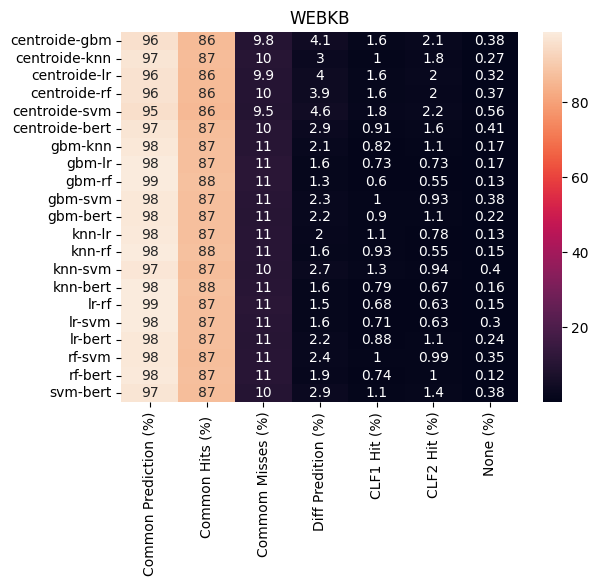

In [14]:
def heatmap(dset, d_preds, pd_datasets, exclude_list=None):
    
    df = pd_datasets[dset]
    rates = pair_wise(d_preds[dset], df, exclude_list=exclude_list)
    ax = plt.axes()
    heatmap = sbn.heatmap(rates.drop(columns=["Pair"]), yticklabels=rates.Pair.values, annot=True)
    _ = ax.set_title(dset.upper())

heatmap("webkb", d_preds, pd_datasets)

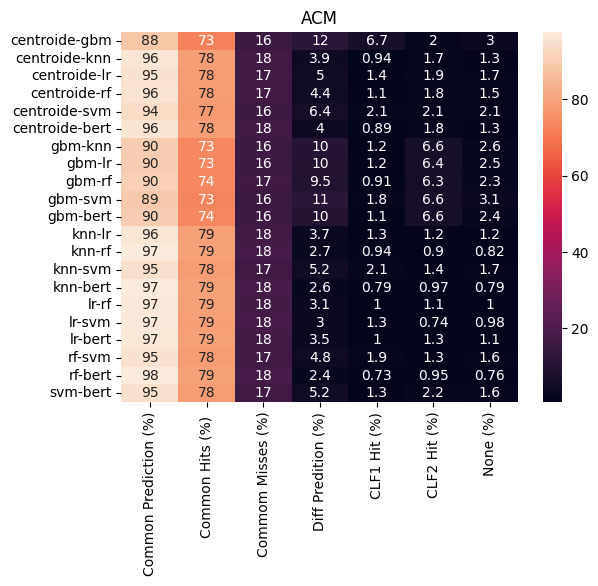

In [15]:
heatmap("acm", d_preds, pd_datasets)

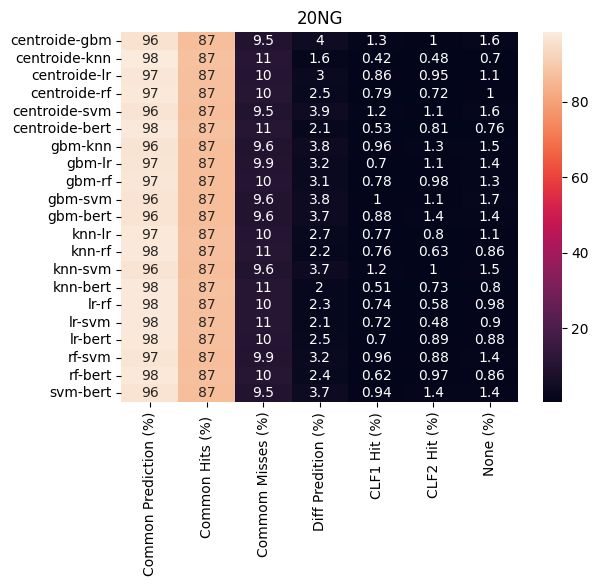

In [16]:
heatmap("20ng", d_preds, pd_datasets)

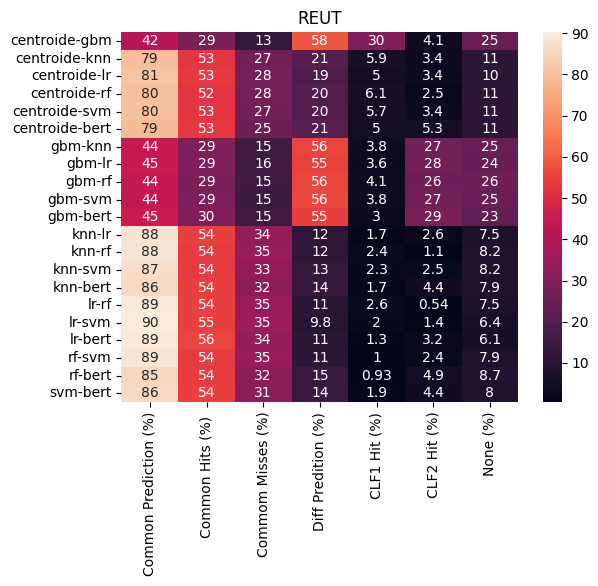

In [17]:
heatmap("reut", d_preds, pd_datasets)

In [18]:
def plot_ag_matrix(dset, ag_matrix, ALGORITHMS, ax):

    #ax = plt.axes()
    heatmap = sbn.heatmap(ag_matrix, xticklabels=ALGORITHMS, yticklabels=ALGORITHMS, annot=True, ax=ax)
    _ = ax.set_title(dset.upper())

def agreement_matrix(preds, df, dset, CLF_ID, ax):

    ms = len(CLF_ID)
    ag_matrix = np.zeros((ms, ms))
    for clf1, clf2 in combinations(preds.keys(), 2):

        p1 = preds[clf1]
        p2 = preds[clf2]

        # Looking at where the classifiers predicted equal.
        total_common = np.sum(p1 == p2) / df.shape[0]
        total_common = np.around(total_common * 100, decimals=2)

        row = CLF_ID[clf1]
        col = CLF_ID[clf2]

        ag_matrix[row][col] = total_common
    plot_ag_matrix(dset, ag_matrix, CLF_ID.keys(), ax)

def hits_aggrement_matrix(preds, df, dset, CLF_ID, ax):

    ms = len(CLF_ID)
    ag_matrix = np.zeros((ms, ms))
    for clf1, clf2 in combinations(preds.keys(), 2):
        p1 = preds[clf1]
        p2 = preds[clf2]

        hits_p1 = df.classes.values == p1
        hits_p2 = df.classes.values == p2

        # Looking at where the classifiers predicted right and equal.
        common_hits = np.sum(hits_p1 * hits_p2) / df.shape[0]
        common_hits = np.around(common_hits * 100, decimals=2)

        row = CLF_ID[clf1]
        col = CLF_ID[clf2]

        ag_matrix[row][col] = common_hits
    plot_ag_matrix(dset, ag_matrix, CLF_ID.keys(), ax)

def misses_agreement_matrix(preds, df, dset, CLF_ID, ax):

    ms = len(CLF_ID)
    ag_matrix = np.zeros((ms, ms))
    for clf1, clf2 in combinations(preds.keys(), 2):
        p1 = preds[clf1]
        p2 = preds[clf2]

        # Looking at where the classifiers predicted wrong and equal.
        misses_p1 = np.where(df.classes.values != p1)[0]
        misses_p2 = np.where(df.classes.values != p2)[0]
        common_misses = np.intersect1d(misses_p1, misses_p2).shape[0]
        global_misses = np.around((common_misses / df.shape[0]) * 100, decimals=2)

        union = np.union1d(misses_p1, misses_p2).shape[0]
        local_misses = np.around((common_misses / union) * 100, decimals=2)
        
        row = CLF_ID[clf1]
        col = CLF_ID[clf2]

        ag_matrix[row][col] = global_misses
    plot_ag_matrix(dset, ag_matrix, CLF_ID.keys(), ax)

In [19]:
np.array([True, False, True, False]) * np.array([True, False, True, True])

array([ True, False,  True, False])

In [20]:
global_agree = {}
hits_agree = {}
for dset in DATASETS:
    global_agree[dset] = []
    df = pd_datasets[dset]
    preds = pd.DataFrame(d_preds[dset]).values
    for idx in np.arange(preds.shape[0]):
        counts = Counter(preds[idx])
        agree_size = counts.most_common()[0][1]
        global_agree[dset].append(agree_size)
    hits_agree[dset] = np.sum(preds == df.classes.values[:, None], axis=1)


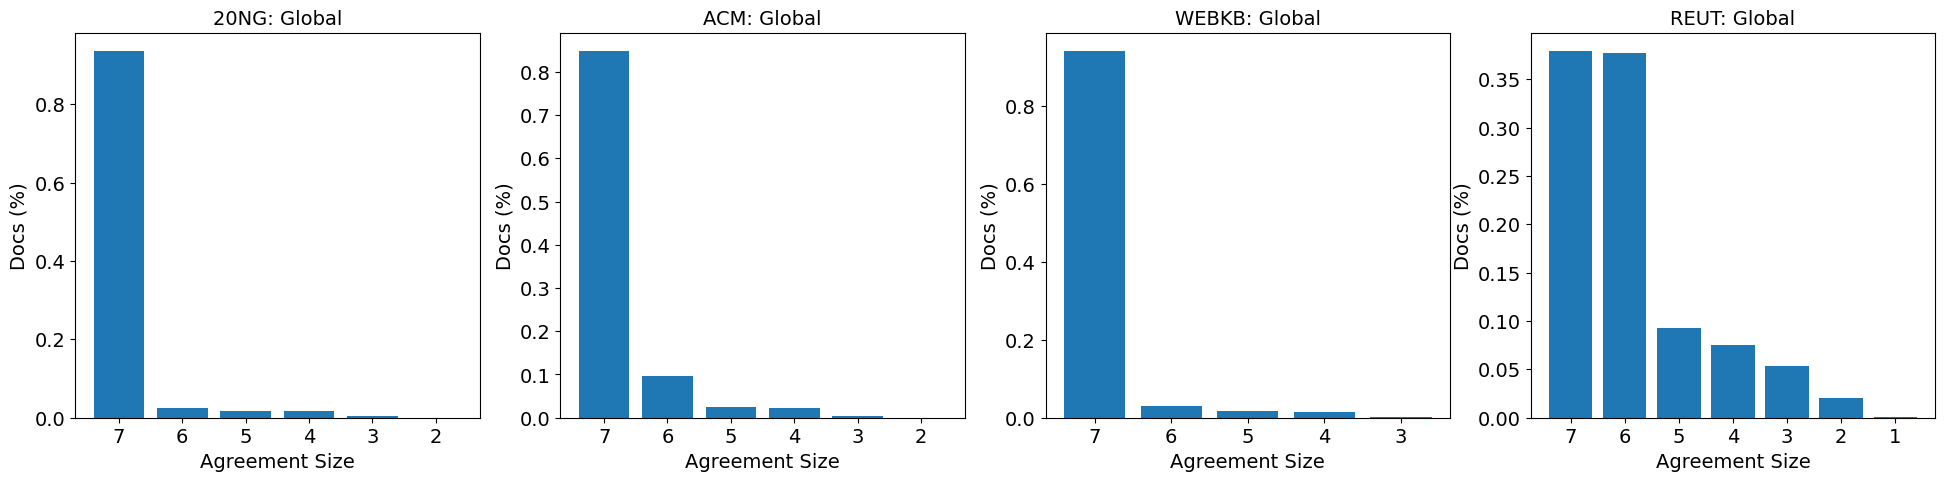

In [21]:
def plot_dists(dset_values, xl="Agreement Size", yl="Docs (%)", kind=None):
    plt.figure(figsize=(24, 5))
    ld = len(DATASETS)
    for plot_idx, dset in enumerate(DATASETS):
        counts = pd.Series(dset_values[dset]).value_counts(normalize=True)
        keys = sorted(list(counts.keys()), reverse=True)
        values = [ counts[key] for key in keys ]
        plt.subplot(1, ld, plot_idx + 1)
        x = np.arange(len(values))
        plt.bar(x, values)
        plt.xticks(ticks=x, labels=keys, fontsize=14)
        plt.yticks(fontsize=14)

        plt.title(f"{dset.upper()}: {kind}", fontsize=14)
        plt.xlabel(xlabel=xl, fontsize=14)
        plt.ylabel(yl, fontsize=14)
    #plt.tight_layout()
kind = "Global"

plot_dists(global_agree, kind="Global")

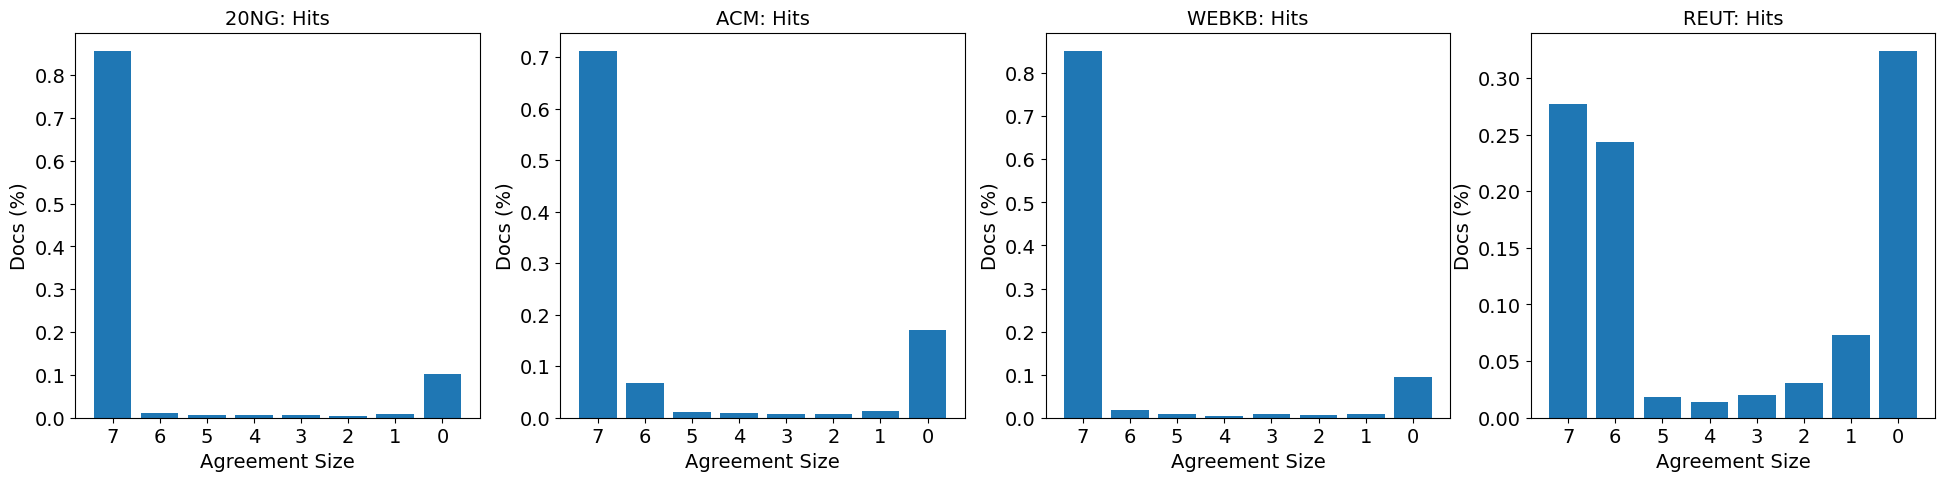

In [22]:
plot_dists(hits_agree, kind="Hits")

In [23]:
orig_stacking = {}
pred_cols = [ col for col in df.columns if col.find("_y_pred") > 0 ]
for dset in DATASETS:
    orig_stacking[dset] = {}
    df = pd_datasets[dset]
    preds = df[pred_cols].values
    labels = df.classes.values
    hits = np.sum(preds == df.classes.values[:, None], axis=1)
    orig_stacking[dset]["hits"] = hits
    orig_stacking[dset]["cout_hits"] = np.sum(hits > 0) / df.shape[0]

In [24]:
bert_stacking = {}
for dset in DATASETS:
    preds = pd.DataFrame(d_preds[dset]).values
    y_true = pd_datasets[dset].classes.values
    hits = np.sum(preds == y_true[:, None], axis=1)
    bert_stacking[dset] = np.sum( hits > 0 ) / preds.shape[0]


In [25]:
def cdf(dist):

    counts = pd.Series(dist).value_counts(normalize=True)
    keys = list(counts.keys())
    keys.sort(reverse=True)
    #total = np.sum(dist)
    acc = 0
    cdf_values = []
    for key in keys:
        acc += counts[key]
        cdf_values.append(acc)
    
    return cdf_values, keys

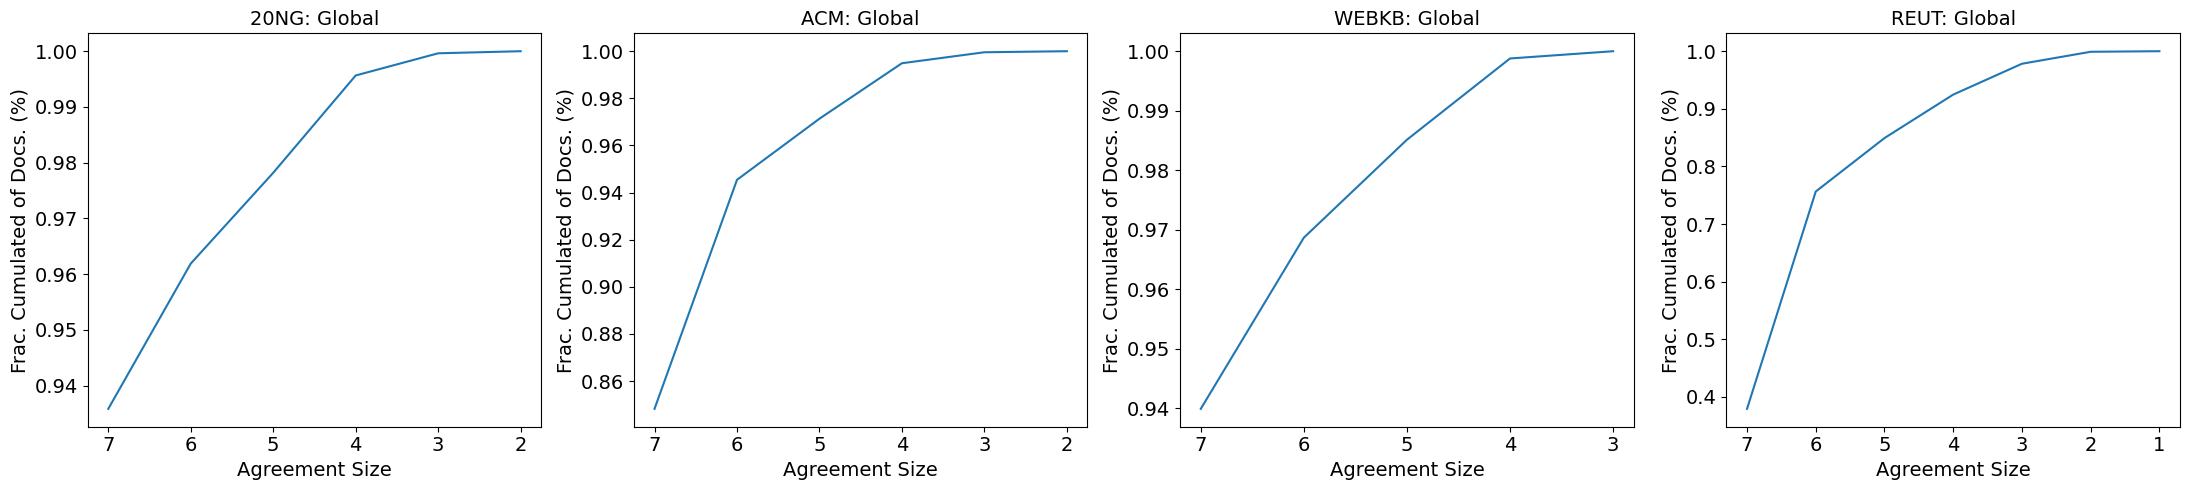

In [26]:
def plot_cdfs(dset_values, xl="Agreement Size", kind=None, bert_stacking=None, orig_stacking=None):
    plt.figure(figsize=(22, 5))
    ld = len(DATASETS)
    for plot_idx, dset in enumerate(DATASETS):
        cdf_values, keys = cdf(dset_values[dset])
        plt.subplot(1, ld, plot_idx + 1)
        x = np.arange(len(cdf_values))
        plt.plot(x, cdf_values)
        plt.xticks(ticks=x, labels=keys, fontsize=14)
        plt.yticks(fontsize=14)

        plt.title(f"{dset.upper()}: {kind}", fontsize=14)
        plt.xlabel(xlabel=xl, fontsize=14)
        plt.ylabel("Frac. Cumulated of Docs. (%)", fontsize=14)

        if bert_stacking is not None:
            plt.axhline(y=bert_stacking[dset], label='Bert Stacking', color="red")
        if orig_stacking is not None:
            plt.axhline(y=orig_stacking[dset]["cout_hits"], label='Original Stacking', color="Blue")
            plt.legend()
            
    plt.tight_layout()
kind = "Global"

plot_cdfs(global_agree, kind="Global")

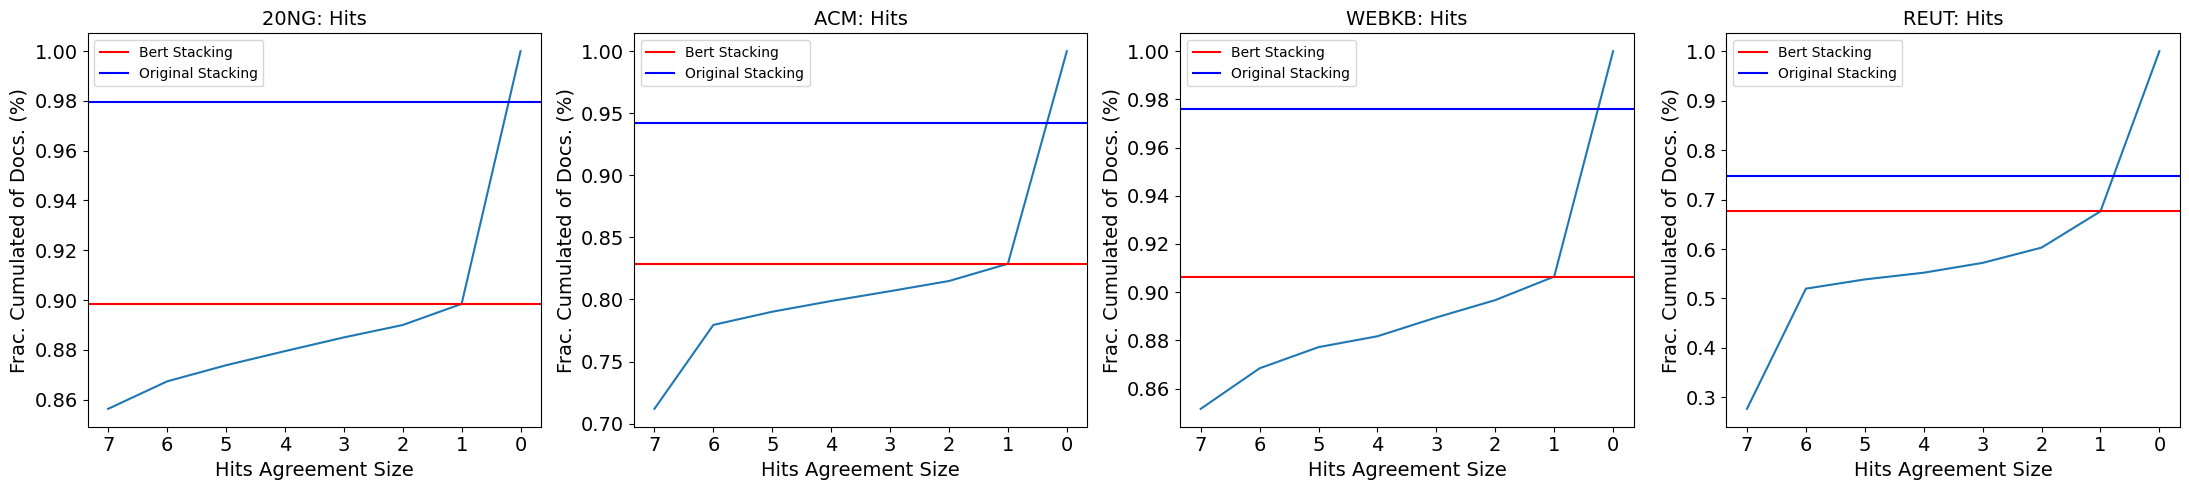

In [27]:
plot_cdfs(hits_agree, "Hits Agreement Size", "Hits", bert_stacking=bert_stacking, orig_stacking=orig_stacking)

In [28]:
def load_bert_reps():
    bert_reps = {}
    for dset in DATASETS:
        reps_list = []
        for fold in np.arange(10):
            file_path = f"/home/welton/data/representations/{dset}/10_folds/split_10_with_val/bert_base/fine_tuning/{fold}/test.npy"
            fold_rep = np.load(file_path, allow_pickle=True)
            reps_list.append(fold_rep)
        bert_reps[dset] = np.vstack(reps_list)
    
    return bert_reps

bert_reps = load_bert_reps()

In [29]:
def scatter_plot(tsne, hits):
    
    for group in range(2, -1, -1):
        x = tsne[:, 0]
        y = tsne[:, 1]
        xg = x[hits == group]
        yg = y[hits == group]
        if group < 2:
            label = f"#Hits: {group}"
        else:
            label = f"#Hits: > 1"
        plt.scatter(xg, yg, label=label, marker='.')#, edgecolors="black")
    plt.legend()

In [30]:
d_tsne = {}
for dset in tqdm(DATASETS):

    tsne_dir = f"data/tsne/{dset}/"
    tsne_path = f"{tsne_dir}/tsne.pickle"
    tsne_results_path = f"{tsne_dir}/tsne_results.pickle"
    if not os.path.exists(tsne_dir):
        os.makedirs(tsne_dir)
        tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=1000, n_jobs=10)
        tsne_results = tsne.fit_transform(bert_reps[dset])
        with open(tsne_path, "wb") as fd:
            pickle.dump(tsne, fd, protocol=pickle.HIGHEST_PROTOCOL)
        with open(tsne_results_path, "wb") as fd:
            pickle.dump(tsne_results, fd, protocol=pickle.HIGHEST_PROTOCOL)
    else:
        with open(tsne_results_path, "rb") as fd:
            tsne_results = pickle.load(fd)
    
    d_tsne[dset] = tsne_results


 25%|██▌       | 1/4 [00:00<00:00, 1512.55it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'data/tsne/acm//tsne_results.pickle'

KeyError: 'acm'

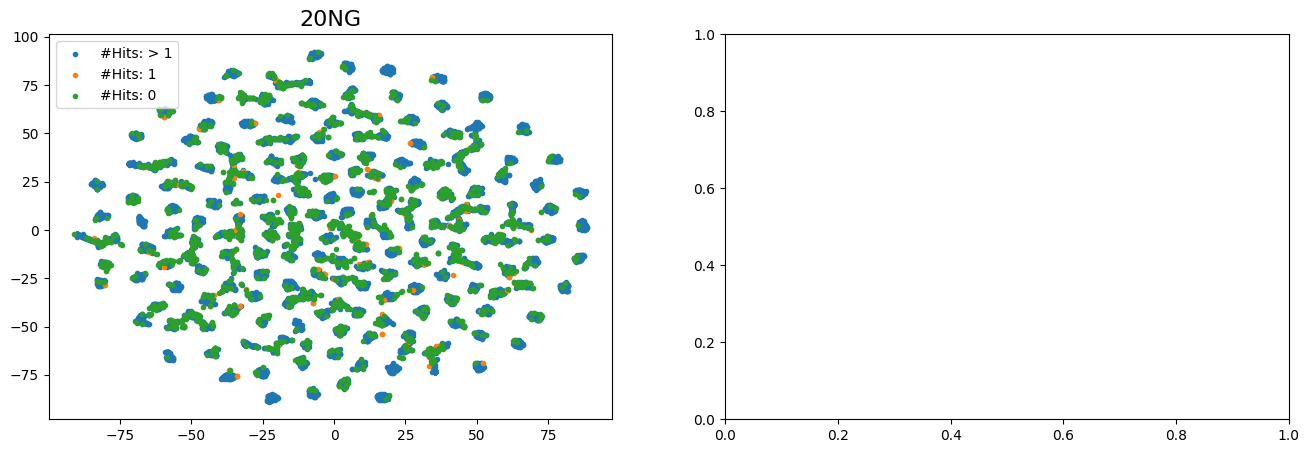

In [31]:
plt.figure(figsize=(16,11))
for pidx, dset in enumerate(DATASETS):
    hits = hits_agree[dset].copy()
    hits[hits > 1] = 2
    plt.subplot(2, 2, pidx+1)
    scatter_plot(d_tsne[dset], hits)
    plt.title(dset.upper(), fontsize=16)

In [32]:
color_list = [ c for c in matplotlib.colors.get_named_colors_mapping() ]

plt.figure(figsize=(16,10))
for pidx, dset in enumerate(["webkb", "acm", "20ng", "reut"]):
    
    tsne_embs = d_tsne[dset]
    df = pd_datasets[dset]
    y_true = df.classes.values
    labels = np.unique(y_true)
    x_cent, y_cent = [], []
    for label, color_id in zip(labels, range(0, len(color_list), 9)):
        x, y = np.mean(tsne_embs[y_true == label], axis=0)
        x_cent.append(x)
        y_cent.append(y)
        plt.subplot(2, 2, pidx + 1)
        hits = hits_agree[dset]
        c1 = y_true == label
        c2 = hits == 0
        points = tsne_embs[np.logical_and(c1, c2)]
        plt.scatter(points[:, 0], points[:, 1], color=color_list[color_id], marker=".")
        plt.scatter([x], [y], [200], color=color_list[color_id], marker="^", edgecolors="black")

    plt.title(dset.upper(), fontsize=16)

KeyError: 'webkb'

<Figure size 1600x1000 with 0 Axes>

In [33]:
_ = """
for dset in DATASETS:
    with open(f"/home/claudiovaliense/projetos/kaggle/dataset/{dset}/splits/split_10_with_val.pkl", 'rb') as fd:
        claudio = pickle.load(fd)
        chrstian = pd.read_pickle(f"/home/christian/arquivado/projeto_stacking/input/{dset}/representations/10_folds_splits.csv")
        for ch, cl in zip(chrstian.test_idxs.values, claudio.test_idxs.values):
            print(set(np.equal(ch, cl)))
"""

# Quais classificadores mais acertaram onde o BERT errou?
## Stacking Christian

(2647,)
(5479,)
(1145,)
(5661,)


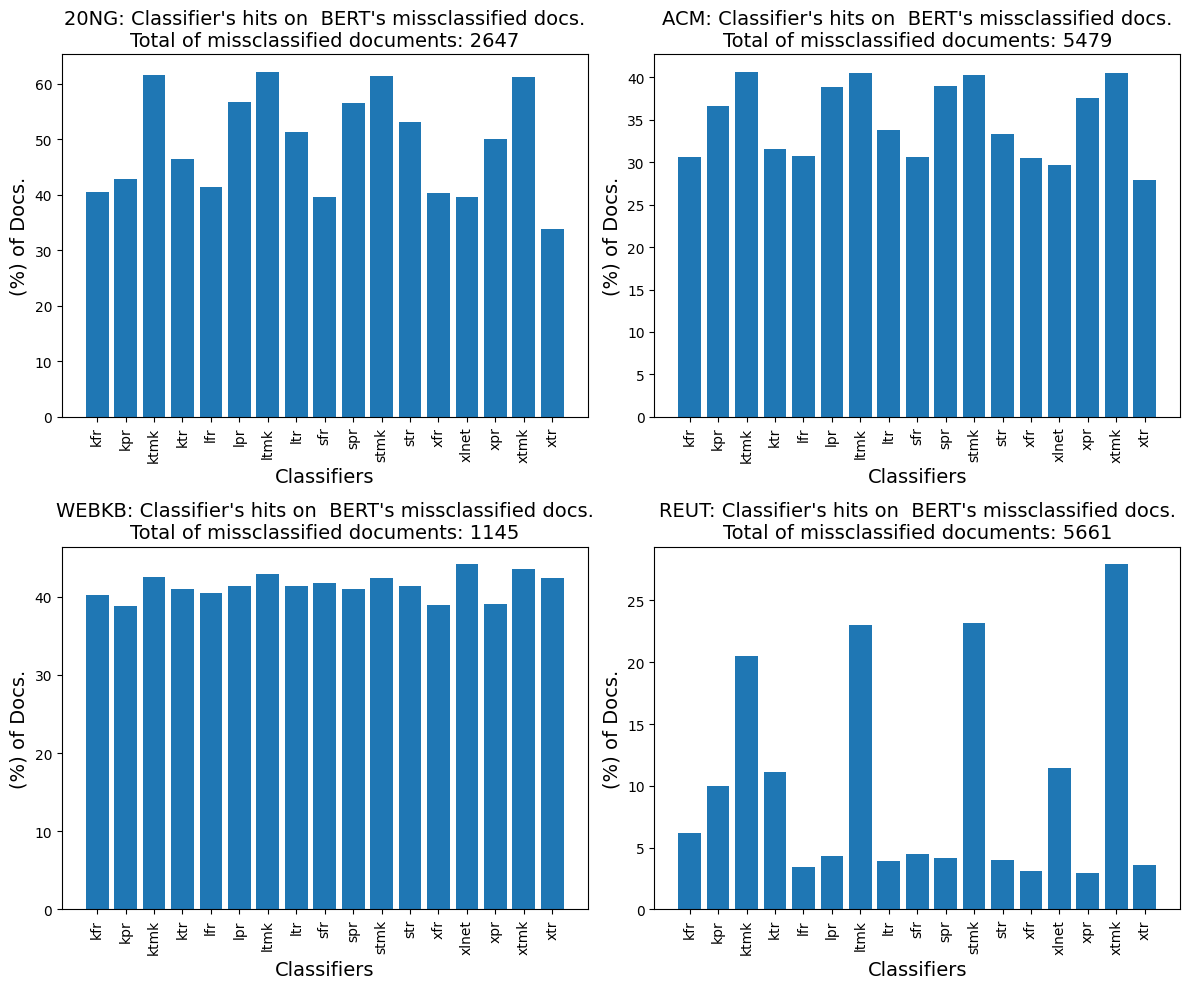

In [34]:
plt.figure(figsize=(12, 10))
for pidx, dset in enumerate(DATASETS):
    df = pd_datasets[dset]
    # Selecionando as colunas com as predições.
    pred_cols = [ col for col in df.columns if col.find("y_pred") > -1 ]
    # Coluna com as predições do BERT.
    bert_preds = df.bert_y_pred.values
    # Columna com as predições dos demais classificadores
    clfs_preds = df[pred_cols].drop(columns=["bert_y_pred"]).values
    # Y true.
    y_true = df.classes.values
    # Selecionando os índices dos documentos onde o BERT errou.
    bert_misses = bert_preds != y_true
    # Selecionando as predições dos demais classificadores onde o BERT errou.
    partial_clfs = clfs_preds[bert_misses]
    # Selecionando o y true onde o BERT errou.
    partial_y = y_true[bert_misses]
    print(partial_y.shape)
    # Comparando o y true com as predições dos demais classificadores.
    hits = partial_clfs == partial_y[:, None]
    # Somando o total de acerto por classificador.
    y_clfs = np.sum(hits, axis=0)
    xticks = [ col.replace("_y_pred", '') for col in df[pred_cols].drop(columns=["bert_y_pred"]).columns ]

    x = np.arange(len(xticks))
    plt.subplot(2, 2, pidx + 1)
    plt.bar(x, (y_clfs / partial_y.shape[0]) * 100)
    plt.title(f"{dset.upper()}: Classifier's hits on  BERT's missclassified docs.\nTotal of missclassified documents: {partial_y.shape[0]}", fontsize=14)
    plt.xticks(ticks=x, labels=xticks, rotation=90)
    plt.ylabel("(%) of Docs.", fontsize=14)
    plt.xlabel("Classifiers", fontsize=14)

plt.tight_layout()

# Quais classificadores acertam mais sozinhos
## Stacking Christian

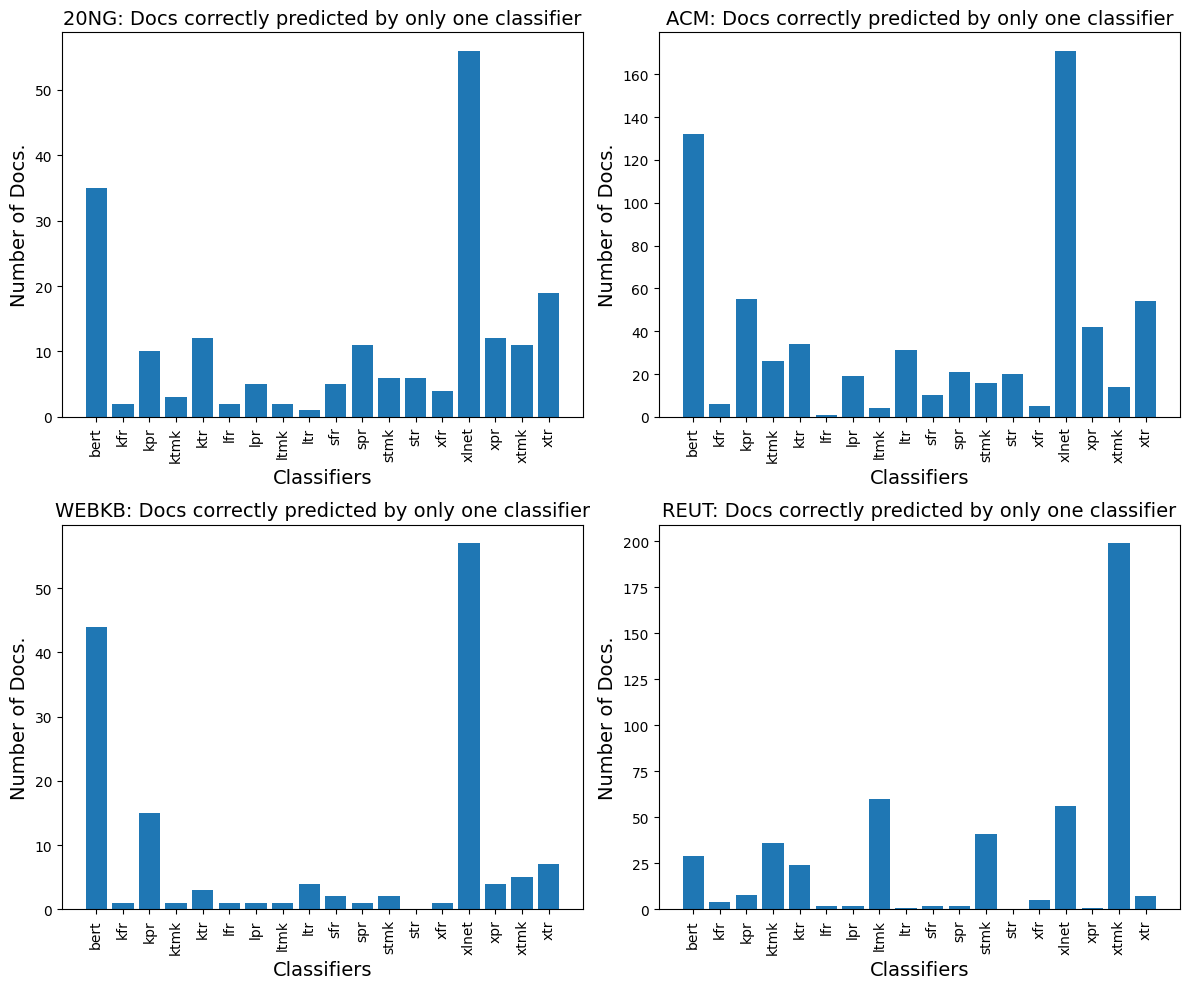

In [35]:
plt.figure(figsize=(12, 10))
for pidx, dset in enumerate(DATASETS):
    df = pd_datasets[dset]
    # Selecionando as colunas com as predições.
    pred_cols = [ col for col in df.columns if col.find("y_pred") > -1 ]
    # Coluna com as predições do BERT.
    clfs_preds = df[pred_cols].values
    y_true = df.classes.values

    hits = clfs_preds == y_true[:, None]
    only_one = np.sum(hits, axis=1) == 1

    y_clfs = np.sum(hits[only_one], axis=0)
    xticks = [ col.replace("_y_pred", '') for col in df[pred_cols].columns ]

    x = np.arange(len(xticks))
    
    plt.subplot(2, 2, pidx + 1)
    plt.bar(x, y_clfs)
    plt.title(f"{dset.upper()}: Docs correctly predicted by only one classifier", fontsize=14)
    plt.xticks(ticks=x, labels=xticks, rotation=90)
    plt.ylabel("Number of Docs.", fontsize=14)
    plt.xlabel("Classifiers", fontsize=14)

plt.tight_layout()

In [ ]:
m = np.array([[1,1], [1,2], [2,1]])
n = np.array([1,1,1])

In [36]:
m == n[:, None]

NameError: name 'm' is not defined

# Quais classificadores mais erraram quando o BERT acertou.
## Bert stacking.

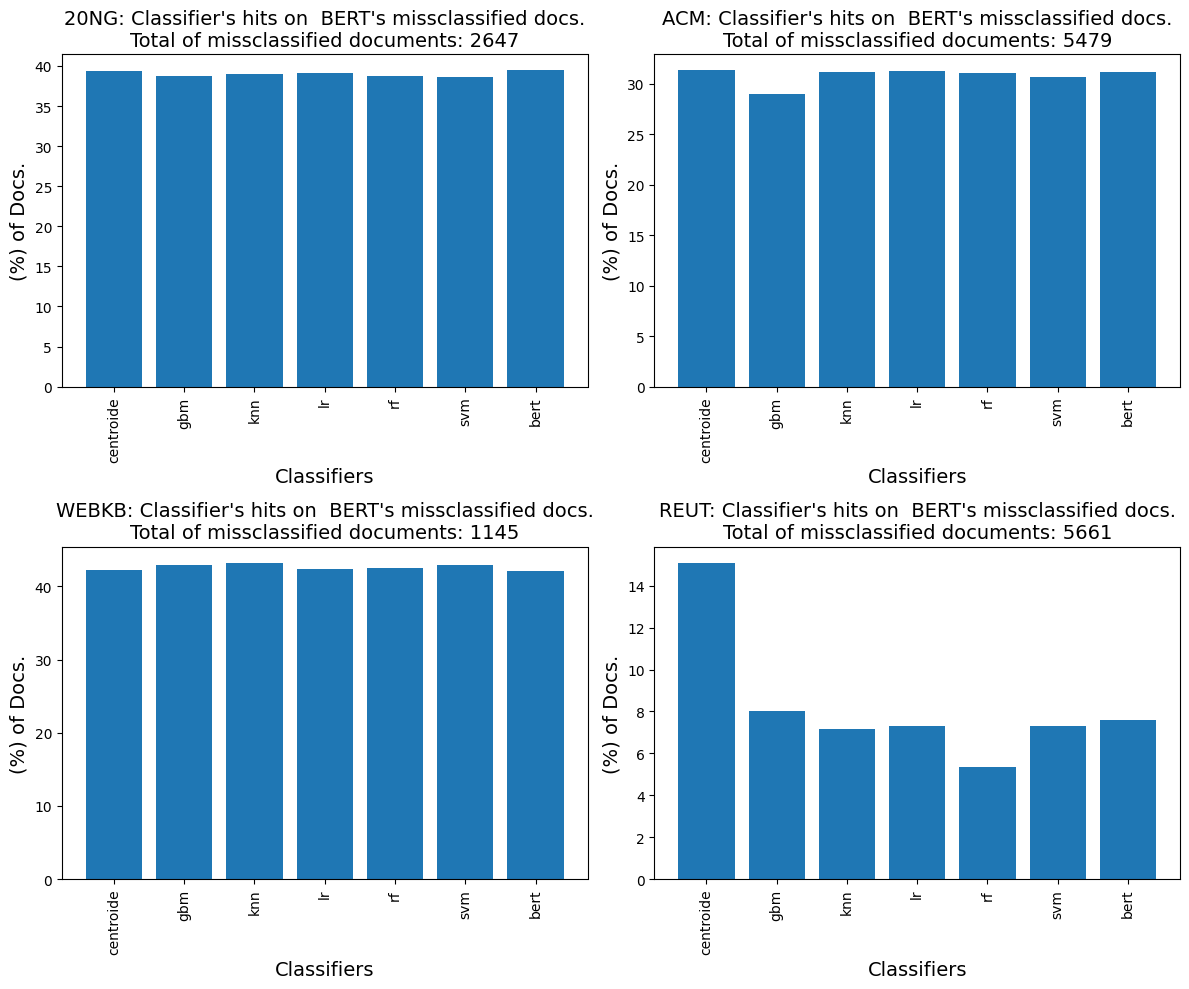

In [37]:
plt.figure(figsize=(12, 10))
for pidx, dset in enumerate(DATASETS):
    df = pd_datasets[dset]
    # Coluna com as predições do BERT.
    bert_preds = df.bert_y_pred.values
    # Matriz com as predições dos demais classificadores
    stacking_df = pd.DataFrame(d_preds[dset])
    clfs_preds = stacking_df.values
    cols = list(stacking_df.columns)
    # Y true.
    y_true = df.classes.values
    # Selecionando os índices dos documentos onde o BERT errou.
    bert_misses = bert_preds != y_true
    # Selecionando as predições dos demais classificadores onde o BERT errou.
    partial_clfs = clfs_preds[bert_misses]
    # Selecionando o y true onde o BERT errou.
    partial_y = y_true[bert_misses]
    # Comparando o y true com as predições dos demais classificadores.
    hits = partial_clfs == partial_y[:, None]
    # Somando o total de acerto por classificador.
    y_clfs = np.sum(hits, axis=0)
    xticks = cols

    x = np.arange(len(xticks))
    plt.subplot(2, 2, pidx + 1)
    plt.bar(x, (y_clfs / partial_y.shape[0]) * 100)
    plt.title(f"{dset.upper()}: Classifier's hits on  BERT's missclassified docs.\nTotal of missclassified documents: {partial_y.shape[0]}", fontsize=14)
    plt.xticks(ticks=x, labels=xticks, rotation=90)
    plt.ylabel("(%) of Docs.", fontsize=14)
    plt.xlabel("Classifiers", fontsize=14)

plt.tight_layout()

# Quais classificadores acertam mais sozinhos
## Bert Stacking

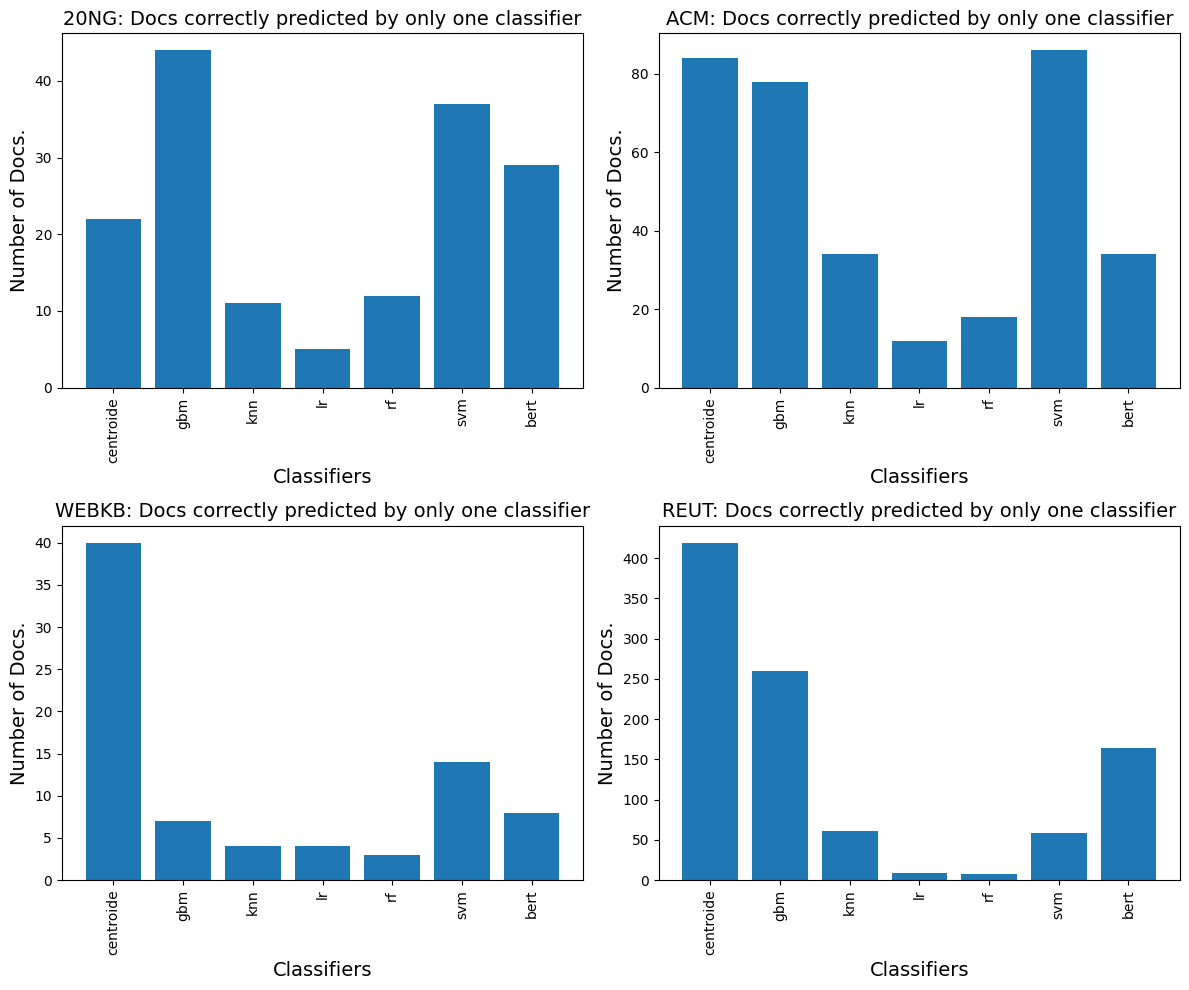

In [38]:
plt.figure(figsize=(12, 10))
for pidx, dset in enumerate(DATASETS):
    df = pd_datasets[dset]
    stacking_df = pd.DataFrame(d_preds[dset])
    # Selecionando as colunas com as predições.
    pred_cols = list(stacking_df.columns)
    # Coluna com as predições do BERT.
    clfs_preds = stacking_df.values
    y_true = df.classes.values
    hits = clfs_preds == y_true[:, None]
    only_one = np.sum(hits, axis=1) == 1
    y_clfs = np.sum(hits[only_one], axis=0)
    xticks = pred_cols
    x = np.arange(len(xticks))
    plt.subplot(2, 2, pidx + 1)
    plt.bar(x, y_clfs)
    plt.title(f"{dset.upper()}: Docs correctly predicted by only one classifier", fontsize=14)
    plt.xticks(ticks=x, labels=xticks, rotation=90)
    plt.ylabel("Number of Docs.", fontsize=14)
    plt.xlabel("Classifiers", fontsize=14)

plt.tight_layout()

# Análise da complementariedade dos modelos base do stacking original com os modelos com base na representação do BERT.

In [39]:
pd_datasets = get_datasets(DATASETS)

In [40]:
base_os = "/home/welton/data/clfs_output/split_10"

In [41]:
ALL_OS_BASE_CLFS = ["sfr", "spr", "str", "stmk", "kfr", "kpr", "ktr", "ktmk", "lfr", "lpr", "ltr", "ltmk", "xfr", "xpr", "xtr", "xtmk", "xlnet", "bert", "rep_bert"]

In [42]:
os_cls_preds = {}
for dset in DATASETS:
    os_cls_preds[dset] = {}
    for clf in ALL_OS_BASE_CLFS:
        lpreds = []
        os_cls_preds[dset][clf] = {}
        for fold in np.arange(10):
            pred_path = f"{base_os}/{dset}/10_folds/{clf}/{fold}/test.npz"
            pred_load = np.load(pred_path, allow_pickle=True)
            preds = pred_load["X_test"].argmax(axis=1)
            lpreds.append(preds)
            os_cls_preds[dset][clf] = np.hstack(lpreds)

In [43]:
macro = {}
macro["CLFs"] = ALL_OS_BASE_CLFS
for dset in DATASETS:
    macro[dset] = []
    for clf in ALL_OS_BASE_CLFS:
        mf1 = f1_score(pd_datasets[dset].classes.values, os_cls_preds[dset][clf], average='macro')
        mf1 = np.round(mf1 * 100, decimals=2)
        macro[dset].append(mf1)


In [44]:
macro_table = pd.DataFrame(macro)

In [45]:
macro_table

,CLFs,20ng,acm,webkb,reut
0,sfr,79.97,61.00,65.87,21.33
1,spr,88.35,62.76,58.35,21.79
2,str,89.21,67.08,71.59,23.34
3,stmk,90.32,68.78,65.39,30.04
4,kfr,80.47,62.86,69.34,21.11
5,kpr,80.47,61.46,59.33,18.35
6,ktr,84.06,59.37,58.83,22.64
7,ktmk,90.27,65.34,64.81,24.39
8,lfr,81.11,62.27,68.40,20.55
9,lpr,88.70,63.44,58.87,21.01


In [46]:
rep_t = macro_table[macro_table.CLFs.str.contains('fr')]
rep_t

,CLFs,20ng,acm,webkb,reut
0,sfr,79.97,61.00,65.87,21.33
4,kfr,80.47,62.86,69.34,21.11
8,lfr,81.11,62.27,68.40,20.55
12,xfr,79.95,61.07,65.62,19.97


In [49]:
meta_features = ['fr', 'pr', 'tr', 'tmk']

In [50]:
from copy import deepcopy


mix_preds = deepcopy(d_preds)

In [51]:
for dset in DATASETS:
    for mf in meta_features:
        rep_t = macro_table[macro_table.CLFs.str.contains(mf)]
        idx = rep_t[dset].values.argmax()
        clf = rep_t['CLFs'].values[idx]
        mix_preds[dset][clf] = os_cls_preds[dset][clf]

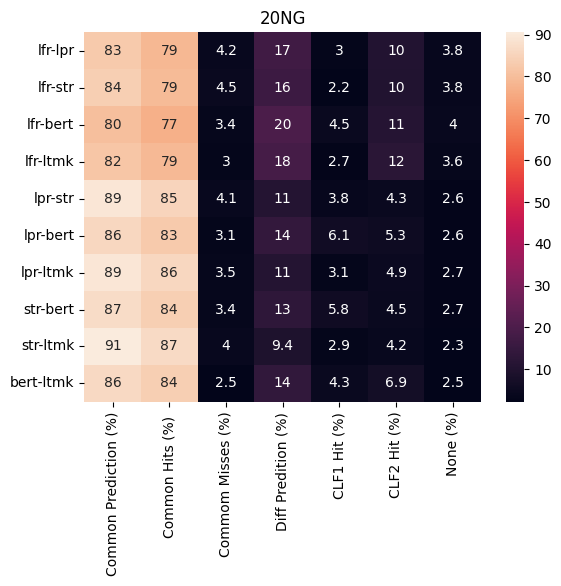

In [52]:
heatmap("20ng", mix_preds, pd_datasets, exclude_list=['centroide', 'svm', 'gbm', 'knn', 'lr', 'rf'])

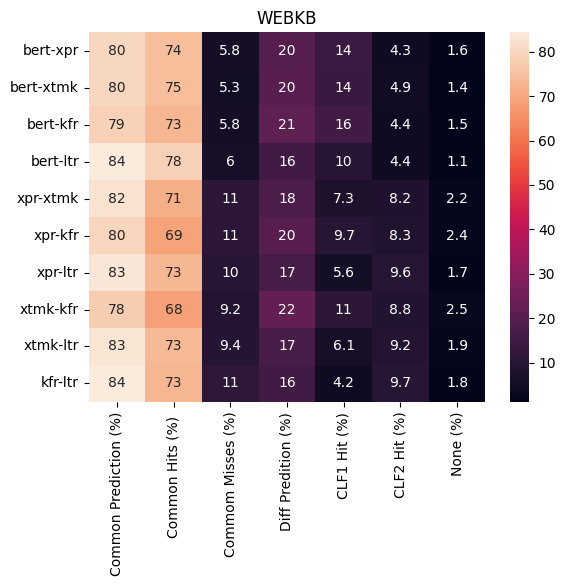

In [ ]:
heatmap("webkb", mix_preds, pd_datasets, exclude_list=['centroide', 'svm', 'gbm', 'knn', 'lr', 'rf'])

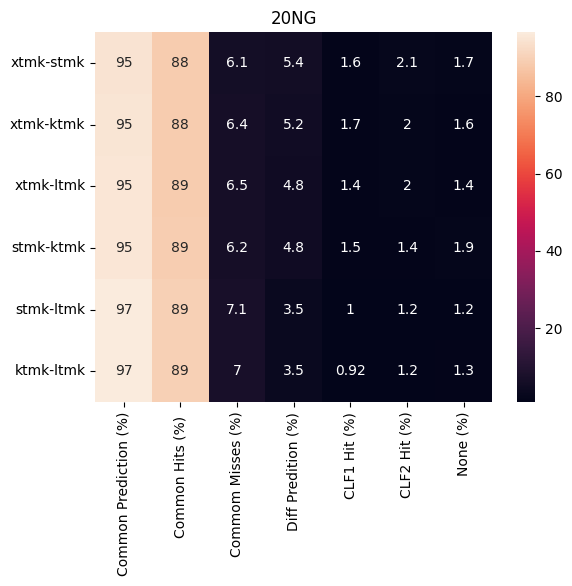

In [ ]:
heatmap("20ng", os_cls_preds, pd_datasets, exclude_list=[ f for f in os_cls_preds["20ng"] if f.find('tmk') < 0 ])

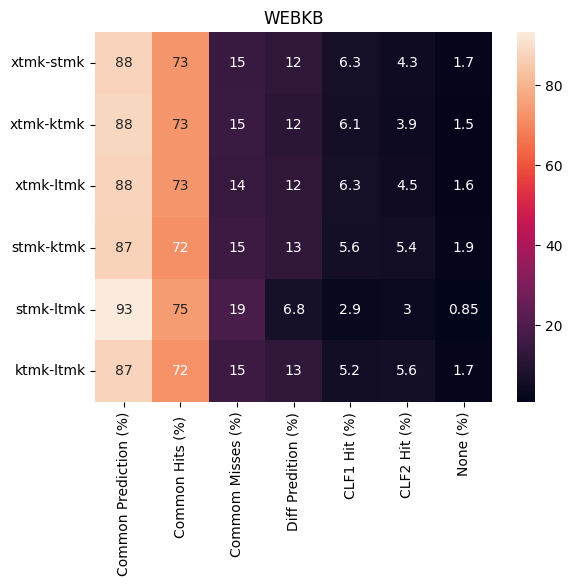

In [ ]:
heatmap("webkb", os_cls_preds, pd_datasets, exclude_list=[ f for f in os_cls_preds["webkb"] if f.find('tmk') < 0 ])

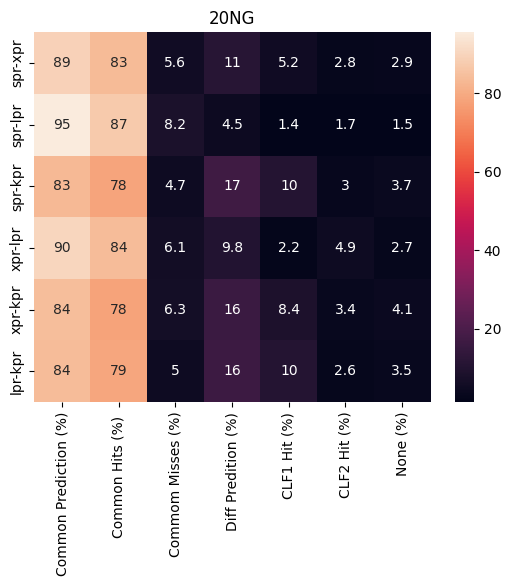

In [ ]:
heatmap("20ng", os_cls_preds, pd_datasets, exclude_list=[ f for f in os_cls_preds["20ng"] if f.find('pr') < 0 ])

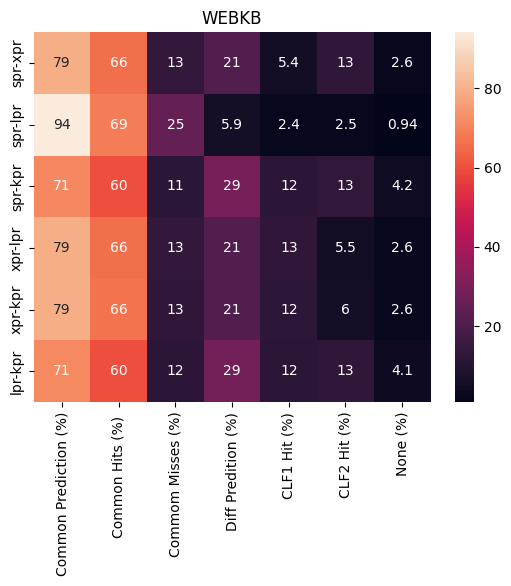

In [ ]:
heatmap("webkb", os_cls_preds, pd_datasets, exclude_list=[ f for f in os_cls_preds["webkb"] if f.find('pr') < 0 ])

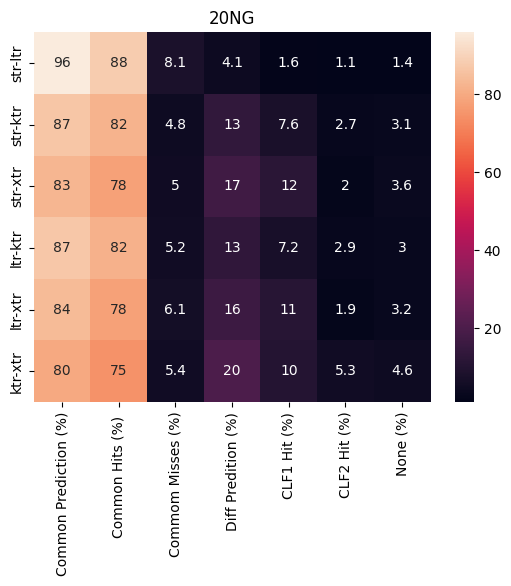

In [ ]:
heatmap("20ng", os_cls_preds, pd_datasets, exclude_list=[ f for f in os_cls_preds["20ng"] if f.find('tr') < 0 ])

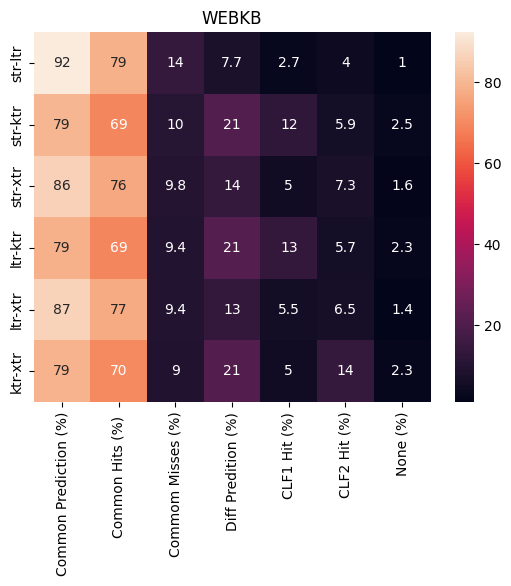

In [ ]:
heatmap("webkb", os_cls_preds, pd_datasets, exclude_list=[ f for f in os_cls_preds["webkb"] if f.find('tr') < 0 ])

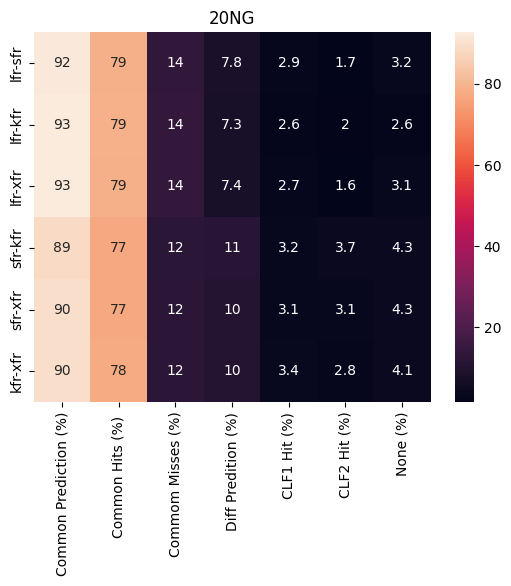

In [ ]:
heatmap("20ng", os_cls_preds, pd_datasets, exclude_list=[ f for f in os_cls_preds["20ng"] if f.find('fr') < 0 ])

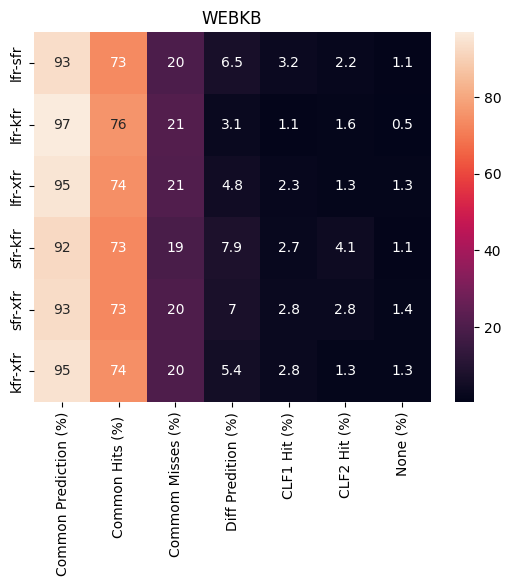

In [ ]:
heatmap("webkb", os_cls_preds, pd_datasets, exclude_list=[ f for f in os_cls_preds["webkb"] if f.find('fr') < 0 ])

In [ ]:
samples = []
df = pd_datasets["20ng"]
for c in np.unique(df.classes.values):
    subdf = df[df.classes == c]
    s = subdf.sample(n=10)
    samples.append(s)

In [ ]:
sdf = pd.concat(samples)

In [ ]:
sdf[["docs", "classes"]].to_excel("data/sample_docs.xlsx")